In [51]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [11]:
# maxdate = session.query(func.max(Measurement.date))
# mindate = session.query(func.min(Measurement.date))

maxdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(maxdate)

('2017-08-23',)


In [12]:
mdate = maxdate[0]
year = int(mdate[0:4])
month = int(mdate[5:7])
day = int(mdate[8:10])
print(year,month, day)

2017 8 23


In [13]:
query_date = dt.date(year, month, day) - dt.timedelta(days=365)
print(query_date)

2016-08-23


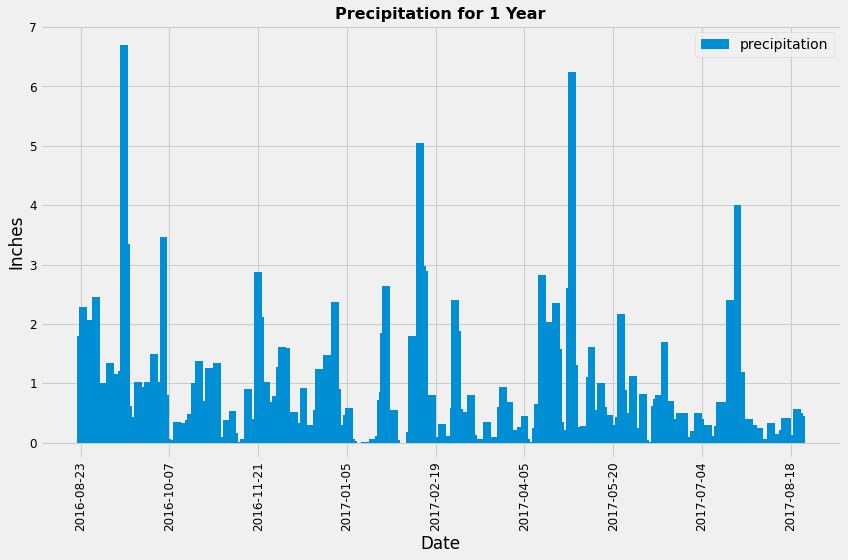

In [73]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(year, month, day) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp = pd.read_sql_query(results, session.bind)

#Sort the dataframe by date
prcp.sort_values('date', inplace=True)

#Reset the index
prcp.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
width = 4
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot()

ax.bar(prcp.index, prcp['prcp'], width, label='precipitation')
ax.xaxis.set_major_locator(MultipleLocator(45))

ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

ax.set_ylim(-.25, max(prcp['prcp'])*1.05)


# # Set a title for the chart
ax.set_title("Precipitation for 1 Year", weight='bold', size=16)
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
ax.legend()
plt.tight_layout()

outfile = os.path.join('Output', 'precipitation_1yr.png')
plt.savefig(outfile)

plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_describe = prcp_sorted.describe()
prcp_describe

,prcp
count,1147.000000
mean,0.312363
std,0.576781
min,0.010000
25%,0.030000
50%,0.100000
75%,0.310000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
unique_stations = session.query(func.count(distinct(Measurement.station)))
print(f'The number of unique stations is {unique_stations[0][0]}')

station_count = session.query(Measurement.station).count()
print(f'The number of non-unique stations (records) is {station_count}')

The number of unique stations is 9
The number of non-unique stations (records) is 19550


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station).label('total')).group_by(Measurement.station).order_by(func.count(Measurement.station).label('total').desc()).all()

print('Station Name   Total')

for active in most_active:
    print(f'{active[0]}    {active[1]}')
    


Station Name   Total
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838    511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_temp = session.query(Measurement.station,func.min(Measurement.tobs).label('min_temp')).filter(Measurement.station == 'USC00519281').first()
print('Station Name   Min Temp')
print(f'{min_temp[0]}    {min_temp[1]}')

max_temp = session.query(Measurement.station,func.max(Measurement.tobs).label('max_temp')).filter(Measurement.station == 'USC00519281').first()
print('\n')
print('Station Name   Max Temp')
print(f'{max_temp[0]}    {max_temp[1]}')

avg_temp = session.query(Measurement.station,func.avg(Measurement.tobs).label('avg_temp')).filter(Measurement.station == 'USC00519281').first()
print('\n')
print('Station Name   Avg Temp')
print(f'{avg_temp[0]}    {round(avg_temp[1],2)}')



Station Name   Min Temp
USC00519281    54.0


Station Name   Max Temp
USC00519281    85.0


Station Name   Avg Temp
USC00519281    71.66


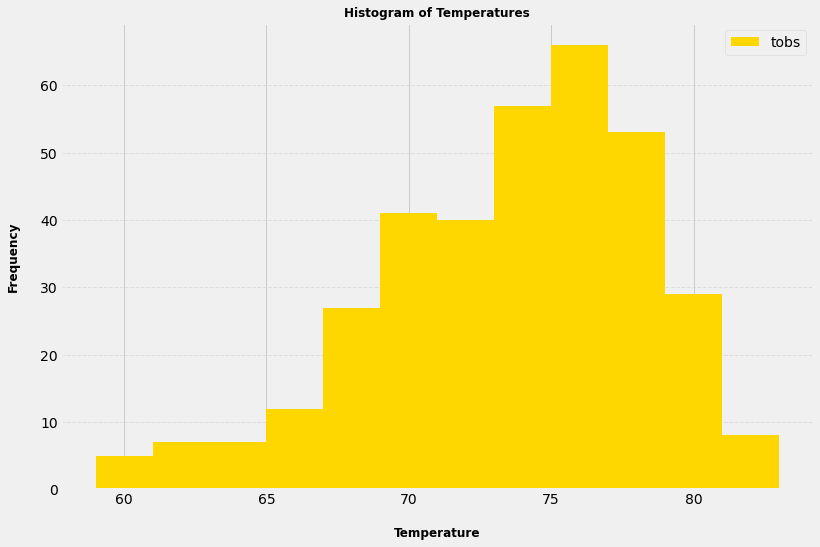

In [71]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tmp_results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= query_date).statement

tmp_df = pd.read_sql_query(tmp_results, session.bind)

plt.figure(figsize=(12,8))
tmp_plot = plt.hist(tmp_df['tobs'],  bins=12, color='gold', zorder=2, rwidth=1, label='tobs')
plt.grid(axis='y', linestyle='--', alpha=.5, zorder=3)
plt.title("Histogram of Temperatures", weight='bold', size=12)
plt.xlabel("Temperature", labelpad=20, weight='bold', size=12)
plt.ylabel("Frequency", labelpad=20, weight='bold', size=12)
plt.legend()

outfile = os.path.join('Output', 'histogram_temperatures.png')
plt.savefig(outfile)

plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

### Temperature Analysis II

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [112]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-01-01'
end_date = '2018-01-01'

tmp_results = calc_temps(start_date, end_date)
print(f'TMin: {tmp_results[0][0]}') 
print(f'TMax: {tmp_results[0][2]}')
print(f'TAvg: {round(tmp_results[0][1],2)}')


TMin: 58.0
TMax: 87.0
TAvg: 74.14


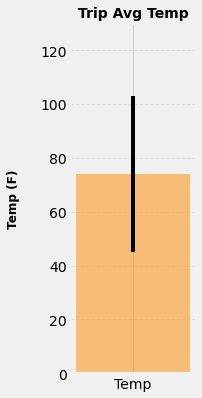

In [113]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = tmp_results[0][2] - tmp_results[0][0]

plt.figure(figsize=(2,6))
plt.bar('Temp', tmp_results[0][1], yerr=yerr, color='darkorange', alpha=.5, zorder=2)
plt.grid(axis='y', linestyle='--', alpha=.5, zorder=3)
plt.title("Trip Avg Temp", weight='bold', size=14)
plt.ylabel("Temp (F)", labelpad=20, weight='bold', size=12)
plt.ylim(0, 130)


outfile = os.path.join('Output', 'trip_avg_temp.png')
plt.savefig(outfile)

plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
most_active = session.query(Measurement.station, func.sum(Measurement.prcp).label('total')).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).label('total').desc()).all()


In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
